In [176]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import IsolationForest

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.callbacks import EarlyStopping

In [177]:
# Load the dataset
data = pd.read_csv("data_after_EDA.csv")
nlp_data = pd.read_csv('updated_dataset.csv', usecols=['Main Diagnosis'] + ['word_' + str(i) for i in range(100)])

# Display the first few rows to understand the structure
print(data.head())
print(nlp_data.head())

  ROWNUM                                  Hospital Eligibility Class  Gender  \
0      1  Royal Commission Health Services Program  ROYAL COMMISSION  Female   
1      2  Royal Commission Health Services Program  ROYAL COMMISSION  Female   
2      3  Royal Commission Health Services Program  ROYAL COMMISSION  Female   
3      4  Royal Commission Health Services Program  ROYAL COMMISSION  Female   
4      5  Royal Commission Health Services Program  ROYAL COMMISSION  Female   

          Arrival Time Severity Level           Deparment  \
0  2023-12-13 13:17:48        Level Ⅳ  Emergency Medicine   
1  2023-12-08 10:59:28        Level Ⅲ  Emergency Medicine   
2  2023-11-05 14:03:02        Level Ⅲ  Emergency Medicine   
3  2023-10-07 22:57:41        Level Ⅲ  Emergency Medicine   
4  2023-10-21 21:32:17        Level Ⅳ  Emergency Medicine   

                                   Main Diagnosis       Discharge Time  \
0                               Pain, unspecified  2023-12-13 16:43:00   
1   

In [178]:
print(data.columns)

Index(['ROWNUM', 'Hospital', 'Eligibility Class', 'Gender', 'Arrival Time',
       'Severity Level', 'Deparment', 'Main Diagnosis', 'Discharge Time',
       'Waiting Time (Minutes)', 'Length of Stay (Minutes)',
       'Treatment Time(Minutes)', 'Cluster', 'No Treatment'],
      dtype='object')


In [179]:
# Drop the 'Main Diagnosis' column
data.drop(columns=['Main Diagnosis','Discharge Time'], inplace=True)

# Convert Arrival Time and Discharge Time to datetime
data['Arrival Time'] = pd.to_datetime(data['Arrival Time'])
data['Hour'] = data['Arrival Time'].dt.hour
data['DayOfYear'] = data['Arrival Time'].dt.dayofyear

print(data.head())

  ROWNUM                                  Hospital Eligibility Class  Gender  \
0      1  Royal Commission Health Services Program  ROYAL COMMISSION  Female   
1      2  Royal Commission Health Services Program  ROYAL COMMISSION  Female   
2      3  Royal Commission Health Services Program  ROYAL COMMISSION  Female   
3      4  Royal Commission Health Services Program  ROYAL COMMISSION  Female   
4      5  Royal Commission Health Services Program  ROYAL COMMISSION  Female   

         Arrival Time Severity Level           Deparment  \
0 2023-12-13 13:17:48        Level Ⅳ  Emergency Medicine   
1 2023-12-08 10:59:28        Level Ⅲ  Emergency Medicine   
2 2023-11-05 14:03:02        Level Ⅲ  Emergency Medicine   
3 2023-10-07 22:57:41        Level Ⅲ  Emergency Medicine   
4 2023-10-21 21:32:17        Level Ⅳ  Emergency Medicine   

   Waiting Time (Minutes)  Length of Stay (Minutes)  Treatment Time(Minutes)  \
0                    14.0                     205.0                    191.0  

In [180]:
# Combine the data with the NLP data
combined_data = data.join(nlp_data, how='left')

In [181]:
# Generate list of NLP feature and time feature columns
feature_columns = ['word_' + str(i) for i in range(100)]
feature_columns += ['DayOfYear']

# Fill missing values with 0 before scaling
combined_data[feature_columns] = combined_data[feature_columns].fillna(0)

# Scale features to [0, 1] - important for neural network models
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(combined_data[feature_columns])

In [196]:
# Weather Data
weather_data = pd.read_csv('Jubail_weather_2023 copy.csv')

weather_data.drop(columns=['name'], inplace=True)

weather_data['datetime'] = pd.to_datetime(weather_data['datetime']).dt.date
weather_data.rename(columns={'datetime': 'Date'}, inplace=True)
print(weather_data.head())

         Date  tempmax  tempmin  temp  feelslikemax  feelslikemin  feelslike  \
0  2023-01-01     25.0     17.3  21.7          25.0          17.3       21.7   
1  2023-01-02     25.6     17.2  21.8          25.6          17.2       21.8   
2  2023-01-03     26.0     20.1  22.5          26.0          20.1       22.5   
3  2023-01-04     27.0     19.2  22.6          26.6          19.2       22.6   
4  2023-01-05     28.0     20.1  23.5          27.4          20.1       23.4   

    dew  humidity  precip  ...  solarenergy  uvindex severerisk  \
0  14.4      63.7     0.0  ...         37.4       10         10   
1  13.0      60.1     0.0  ...         35.1       10         10   
2  10.8      48.1     0.0  ...         34.4        9         10   
3   8.4      41.4     0.0  ...         22.8        6         10   
4  10.9      45.7     0.0  ...         16.6        7         10   

               sunrise               sunset  moonphase        conditions  \
0  2023-01-01T07:04:18  2023-01-01T17:39

# Autoencoder

In [182]:
# Split the data into training and testing sets
X_train, X_test = train_test_split(scaled_features, test_size=0.2, random_state=42, shuffle=True)

In [183]:
# Build the Autoencoder Model

# Define the autoencoder model
input_dim = X_train.shape[1]
input_layer = Input(shape=(input_dim,))

# Encoder
encoded = Dense(128, activation='relu')(input_layer) #16
encoded = Dense(64, activation='relu')(encoded) #8

# Decoder
# decoded = Dense(input_dim, activation='sigmoid')(encoded)
decoded = Dense(128, activation='relu')(encoded) #16
decoded = Dense(input_dim, activation='sigmoid')(decoded)

# Model
autoencoder = Model(inputs=input_layer, outputs=decoded)

# Compile the model
from tensorflow.keras.optimizers import Adam

autoencoder.compile(optimizer=Adam(learning_rate=0.0001), loss='mean_squared_error')

In [184]:
# Train the autoencoder
callbacks = [EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]

history = autoencoder.fit(X_train, X_train, 
                          epochs=50, 
                          batch_size=256, 
                          shuffle=True,
                          validation_data=(X_test, X_test),
                          callbacks=callbacks,
                          verbose=1)

Epoch 1/50
304/304 [==============================] - 5s 4ms/step - loss: 0.1257 - val_loss: 0.0270
Epoch 2/50
304/304 [==============================] - 1s 3ms/step - loss: 0.0231 - val_loss: 0.0198
Epoch 3/50
304/304 [==============================] - 1s 4ms/step - loss: 0.0168 - val_loss: 0.0142
Epoch 4/50
304/304 [==============================] - 1s 3ms/step - loss: 0.0126 - val_loss: 0.0115
Epoch 5/50
304/304 [==============================] - 1s 2ms/step - loss: 0.0109 - val_loss: 0.0105
Epoch 6/50
304/304 [==============================] - 1s 2ms/step - loss: 0.0103 - val_loss: 0.0100
Epoch 7/50
304/304 [==============================] - 1s 3ms/step - loss: 0.0098 - val_loss: 0.0096
Epoch 8/50
304/304 [==============================] - 1s 3ms/step - loss: 0.0095 - val_loss: 0.0093
Epoch 9/50
304/304 [==============================] - 1s 4ms/step - loss: 0.0093 - val_loss: 0.0092
Epoch 10/50
304/304 [==============================] - 1s 3ms/step - loss: 0.0092 - val_loss: 0.0092

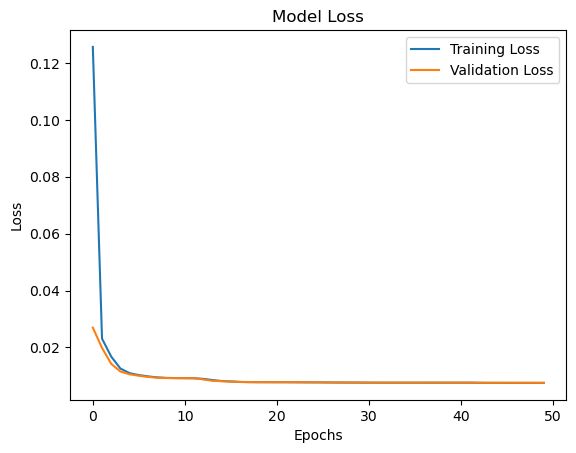

In [185]:
# Plot training loss and validation loss over epochs
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

607/607 [==============================] - 1s 971us/step


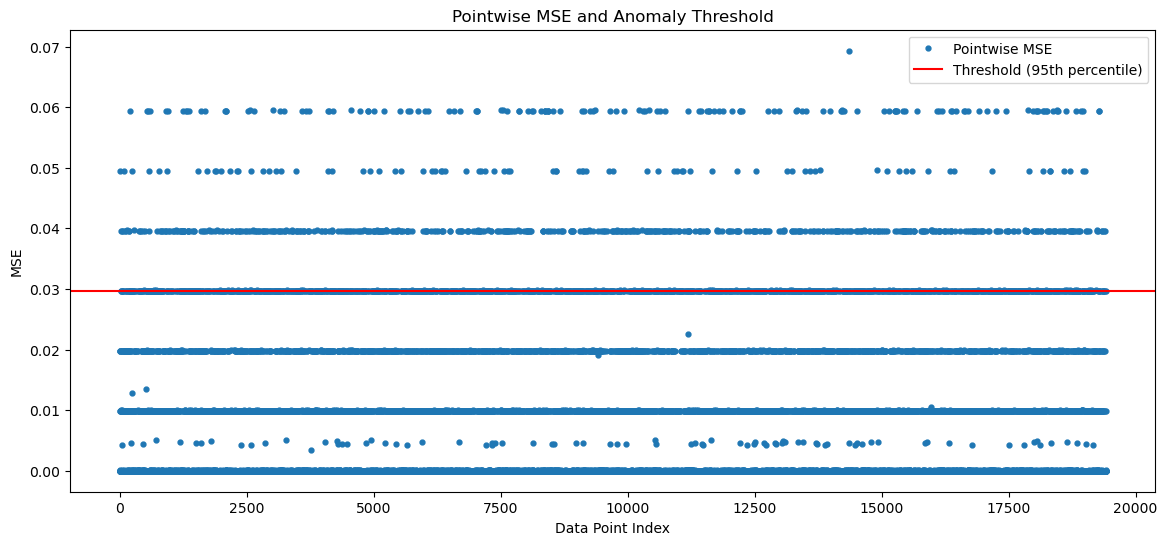

In [186]:
# Detect Anomalies Using Reconstruction Error

# Get the reconstruction loss on the test set
predictions = autoencoder.predict(X_test)

# Compute reconstruction error
mse = np.mean(np.power(X_test - predictions, 2), axis=1)

# Set a threshold for anomaly detection
mse_threshold = np.quantile(mse, 0.95) 

# Mark data points with errors above the threshold as anomalies
outliers = mse > mse_threshold

# Plot the pointwise MSE and the anomaly threshold
plt.figure(figsize=(14, 6))
plt.plot(mse, marker='o', ms=3.5, linestyle='', label='Pointwise MSE')
plt.axhline(y=mse_threshold, color='r', linestyle='-', label='Threshold (95th percentile)')
plt.title('Pointwise MSE and Anomaly Threshold')
plt.xlabel('Data Point Index')
plt.ylabel('MSE')
plt.legend()
plt.show()

In [187]:
# Find the indices of the anomalies
anomaly_indices = np.where(outliers)[0]

# Print details of the anomalies
print("Anomaly Indices:", anomaly_indices)
print("MSE:", mse[outliers])

Anomaly Indices: [    4    18    56    66    70    96   107   123   142   183   191   196
   231   235   277   387   403   424   469   488   505   545   555   585
   587   602   638   667   670   709   736   752   775   802   811   814
   836   849   902   904   913   914   930   950   964   974  1025  1065
  1079  1119  1121  1122  1182  1189  1202  1225  1235  1249  1250  1252
  1255  1260  1265  1268  1270  1311  1320  1338  1343  1344  1365  1375
  1427  1437  1438  1471  1473  1544  1561  1602  1603  1627  1649  1665
  1679  1698  1730  1756  1780  1822  1827  1864  1871  1886  1888  1911
  1963  1970  1989  2009  2036  2070  2101  2103  2111  2127  2165  2191
  2203  2215  2231  2290  2294  2318  2325  2338  2340  2355  2359  2376
  2412  2459  2475  2488  2526  2535  2562  2567  2568  2579  2586  2629
  2630  2653  2662  2681  2701  2714  2740  2741  2784  2811  2814  2821
  2835  2842  2885  2909  2941  2965  3000  3010  3023  3030  3062  3071
  3115  3125  3143  3163  3164  31

In [188]:
# Display the features of the anomalies
if len(anomaly_indices) > 0:
    anomalies_data_auto = combined_data.iloc[anomaly_indices]
    print("\nAnomalies Features:")
    print(anomalies_data_auto)


Anomalies Features:
       ROWNUM                                  Hospital Eligibility Class  \
4           5  Royal Commission Health Services Program  ROYAL COMMISSION   
18         19  Royal Commission Health Services Program            EXEMPT   
56         57  Royal Commission Health Services Program            EXEMPT   
66         67  Royal Commission Health Services Program  ROYAL COMMISSION   
70         71  Royal Commission Health Services Program            EXEMPT   
...       ...                                       ...               ...   
19280  19,283  Royal Commission Health Services Program  ROYAL COMMISSION   
19334  19,337  Royal Commission Health Services Program  ROYAL COMMISSION   
19344  19,347  Royal Commission Health Services Program            EXEMPT   
19385  19,388  Royal Commission Health Services Program  ROYAL COMMISSION   
19394  19,397  Royal Commission Health Services Program  ROYAL COMMISSION   

       Gender        Arrival Time Severity Level      

## Anomaly Date

d:\Anaconda3\envs\prmls_new\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


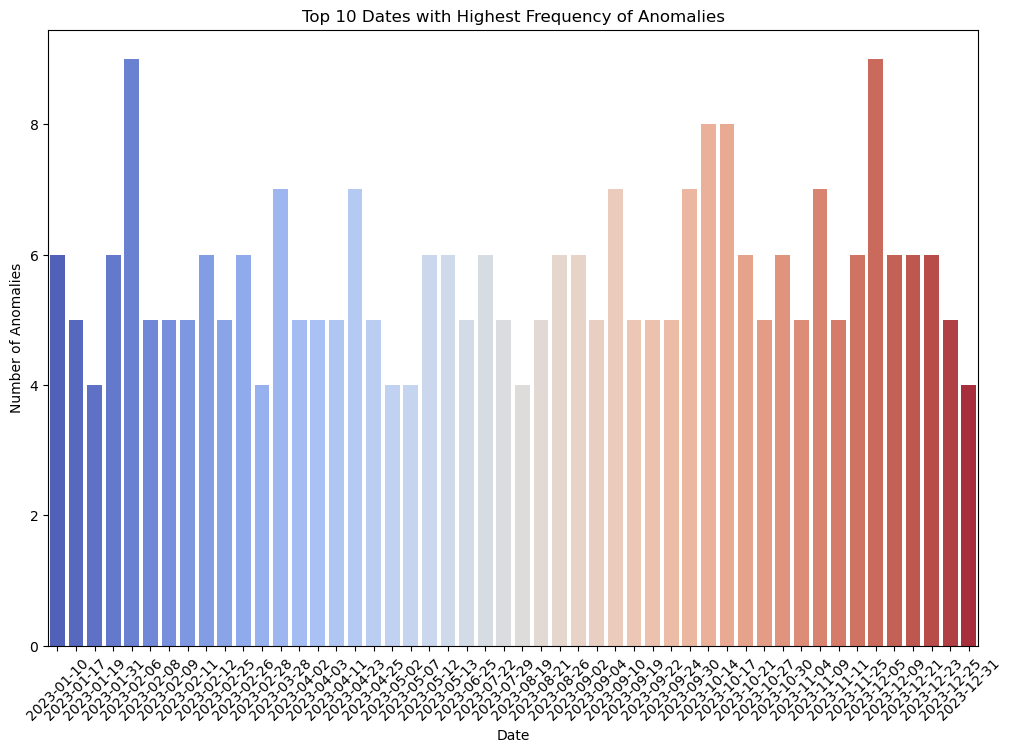

In [190]:
# Abstract the date and time (including the hour)
anomalies_data_auto['Date'] = anomalies_data_auto['Arrival Time'].dt.date
date_counts_auto = anomalies_data_auto['Date'].value_counts().nlargest(50)

date_counts_auto = date_counts_auto.sort_index()

plt.figure(figsize=(12, 8))
sns.barplot(x=date_counts_auto.index, y=date_counts_auto.values, palette='coolwarm')
plt.xticks(rotation=45)
plt.title('Top 50 Dates with Highest Frequency of Anomalies')
plt.xlabel('Date')
plt.ylabel('Number of Anomalies')
plt.show()

In [191]:
df_auto = pd.DataFrame(date_counts_auto).reset_index()
df_auto.columns = ['Date', 'Count_Auto']
print(df_auto)

          Date  Count_Auto
0   2023-01-10           6
1   2023-01-17           5
2   2023-01-19           4
3   2023-01-31           6
4   2023-02-06           9
5   2023-02-08           5
6   2023-02-09           5
7   2023-02-11           5
8   2023-02-12           6
9   2023-02-25           5
10  2023-02-26           6
11  2023-02-28           4
12  2023-03-28           7
13  2023-04-02           5
14  2023-04-03           5
15  2023-04-11           5
16  2023-04-23           7
17  2023-04-25           5
18  2023-05-02           4
19  2023-05-07           4
20  2023-05-12           6
21  2023-05-13           6
22  2023-06-25           5
23  2023-07-22           6
24  2023-07-29           5
25  2023-08-19           4
26  2023-08-21           5
27  2023-08-26           6
28  2023-09-02           6
29  2023-09-04           5
30  2023-09-10           7
31  2023-09-19           5
32  2023-09-22           5
33  2023-09-24           5
34  2023-09-30           7
35  2023-10-14           8
3

## Weather

In [195]:
# Combine the anomalies data with weather data
matched_weather = pd.merge(df_auto, weather_data, on='Date', how='inner')
print(matched_weather)

          Date  Count_Auto  tempmax  tempmin  temp  feelslikemax  \
0   2023-01-10           6     29.0     17.8  22.5          28.9   
1   2023-01-17           5     29.0     17.8  22.2          28.0   
2   2023-01-19           4     24.0     19.4  21.8          24.0   
3   2023-01-31           6     27.8     13.9  20.4          26.7   
4   2023-02-06           9     27.0     16.8  21.3          26.9   
5   2023-02-08           5     29.9     22.0  24.3          28.7   
6   2023-02-09           5     24.0     20.0  21.7          24.0   
7   2023-02-11           5     24.0     14.7  19.5          24.0   
8   2023-02-12           6     29.0     16.2  21.7          27.8   
9   2023-02-25           5     32.7     19.0  25.0          30.9   
10  2023-02-26           6     33.0     21.3  26.2          31.5   
11  2023-02-28           4     33.0     21.4  26.8          30.9   
12  2023-03-28           7     29.0     23.2  25.8          28.3   
13  2023-04-02           5     25.0     22.0  23

In [197]:
weather_summary = matched_weather.describe()
print("Weather Features Summary:")
print(weather_summary)

Weather Features Summary:
       Count_Auto    tempmax    tempmin      temp  feelslikemax  feelslikemin  \
count   50.000000  50.000000  50.000000  50.00000     50.000000      50.00000   
mean     5.660000  33.520000  24.304000  28.54600     35.862000      25.82200   
std      1.188551   5.868526   5.665036   5.54673      9.579056       7.86966   
min      4.000000  24.000000  13.900000  19.50000     24.000000      13.90000   
25%      5.000000  29.000000  19.550000  23.45000     28.225000      19.55000   
50%      5.000000  33.200000  23.550000  28.05000     32.600000      23.55000   
75%      6.000000  38.500000  28.300000  33.35000     42.450000      30.85000   
max      9.000000  44.000000  34.600000  38.40000     55.400000      43.40000   

       feelslike        dew   humidity     precip  ...  windspeed     winddir  \
count  50.000000  50.000000  50.000000  50.000000  ...  50.000000   50.000000   
mean   30.688000  17.238000  53.342000   0.166000  ...  23.226000  213.068000   
s

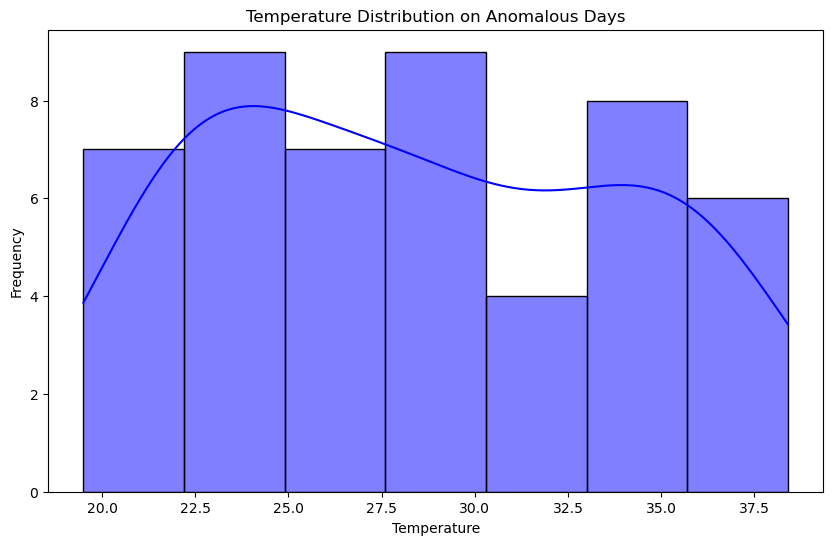

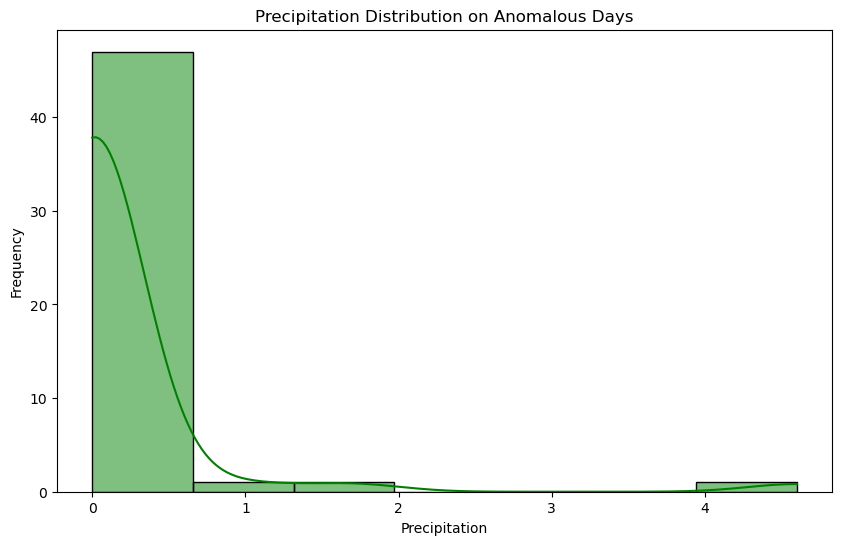

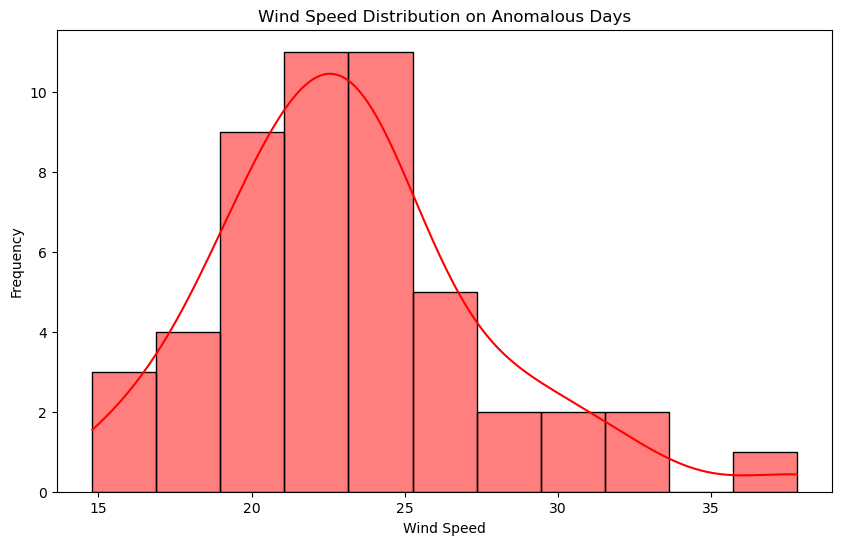

In [199]:
# Plot the weather features on anomalous days

# Temperature
plt.figure(figsize=(10, 6))
sns.histplot(matched_weather['temp'], kde=True, color='blue')
plt.title('Temperature Distribution on Anomalous Days')
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.show()

# Precipitation
plt.figure(figsize=(10, 6))
sns.histplot(matched_weather['precip'], kde=True, color='green')
plt.title('Precipitation Distribution on Anomalous Days')
plt.xlabel('Precipitation')
plt.ylabel('Frequency')
plt.show()

# Wind Speed
plt.figure(figsize=(10, 6))
sns.histplot(matched_weather['windspeed'], kde=True, color='red')
plt.title('Wind Speed Distribution on Anomalous Days')
plt.xlabel('Wind Speed')
plt.ylabel('Frequency')
plt.show()

## Anomalies of Main Diagnosis

In [170]:
# Visualize the frequency of main diagnosis for anomalies
diagnosis_counts_auto = anomalies_data_auto['Main Diagnosis'].value_counts()
print("Number of Main Diagnoses for Anomalies:",diagnosis_counts_auto.count())

plt.figure(figsize=(100, 100))
# sns.countplot(y='Main Diagnosis', data=anomalies_data_auto)
sns.barplot(x=diagnosis_counts_auto.values, y=diagnosis_counts_auto.index, palette='viridis')
plt.title('Frequency of Main Diagnosis for Anomalies')
plt.xlabel('Count')
plt.ylabel('Main Diagnosis')
plt.show()

Number of Main Diagnoses for Anomalies: 188


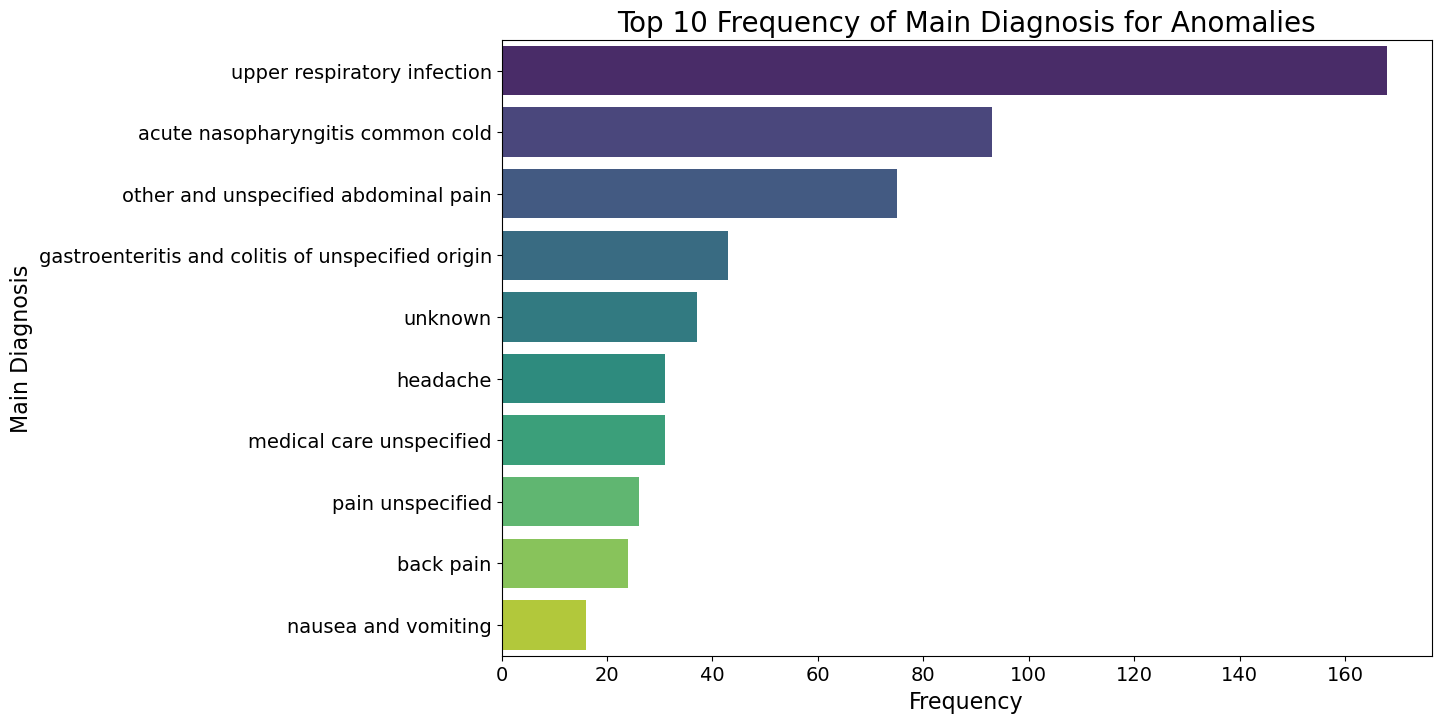

Top 10 Anomalous Main Diagnoses (Autoencoder):
1. upper respiratory infection
2. acute nasopharyngitis common cold
3. other and unspecified abdominal pain
4. gastroenteritis and colitis of unspecified origin
5. unknown
6. headache
7. medical care unspecified
8. pain unspecified
9. back pain
10. nausea and vomiting


In [207]:
# Caculate the frequency of diagnoses and sort the top 10
diagnosis_counts_auto = anomalies_data_auto['Main Diagnosis'].value_counts().nlargest(10)

# Plot the frequency of the top 10 diagnoses
plt.figure(figsize=(12, 8))
sns.barplot(y=diagnosis_counts_auto.index, x=diagnosis_counts_auto.values, palette='viridis')

plt.title('Top 10 Frequency of Main Diagnosis for Anomalies', fontsize=20)
plt.xlabel('Frequency', fontsize=16)
plt.ylabel('Main Diagnosis', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

print("Top 10 Anomalous Main Diagnoses (Autoencoder):")
for idx, diagnosis in enumerate(diagnosis_counts_auto.index, start=1):
    print(f"{idx}. {diagnosis}")

# Isolation Forest

In [141]:
# Standardization
scaler = StandardScaler()
scaled_features = scaler.fit_transform(combined_data[feature_columns])

In [142]:
# Initialize the Isolation Forest model
iso_forest = IsolationForest(n_estimators=100, contamination=0.05, random_state=42)

# Fit the model to the data
iso_forest.fit(scaled_features)

# Predict anomalies (-1 means anomaly, 1 means normal)
predictions = iso_forest.predict(scaled_features)

# Add predictions to the original data (for easier analysis)
combined_data['anomaly'] = predictions

# Display the count of anomalies detected
print("Anomalies detected:", np.sum(predictions == -1))

d:\Anaconda3\envs\prmls_new\lib\site-packages\sklearn\ensemble\iforest.py:247: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
d:\Anaconda3\envs\prmls_new\lib\site-packages\sklearn\ensemble\bagging.py:313: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif isinstance(self.max_features, np.float):
d:\Anaconda3\envs\prmls_new\lib\site-packages\sklearn\ensemble\base.py:158: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing th

Anomalies detected: 4821


In [143]:
# Filter the data to show only the anomalies
anomalies_data_iso = combined_data[combined_data['anomaly'] == -1]

# Display the first few anomalies
print("Anomalous Data:")
print(anomalies_data_iso.head())

Anomalous Data:
   ROWNUM                                  Hospital Eligibility Class  Gender  \
8       9  Royal Commission Health Services Program            EXEMPT    Male   
83     84  Royal Commission Health Services Program         INSURANCE  Female   
84     85  Royal Commission Health Services Program         INSURANCE  Female   
85     86  Royal Commission Health Services Program         INSURANCE  Female   
88     89  Royal Commission Health Services Program            EXEMPT  Female   

          Arrival Time Severity Level           Deparment  \
8  2023-07-20 19:54:45        Level Ⅴ  Emergency Medicine   
83 2023-01-22 09:49:59        Level Ⅳ  Emergency Medicine   
84 2023-01-20 18:46:50        Level Ⅴ  Emergency Medicine   
85 2023-01-18 11:46:22        Level Ⅳ  Emergency Medicine   
88 2023-01-10 19:26:05        Level Ⅳ  Emergency Medicine   

    Waiting Time (Minutes)  Length of Stay (Minutes)  Treatment Time(Minutes)  \
8                      7.0                      1

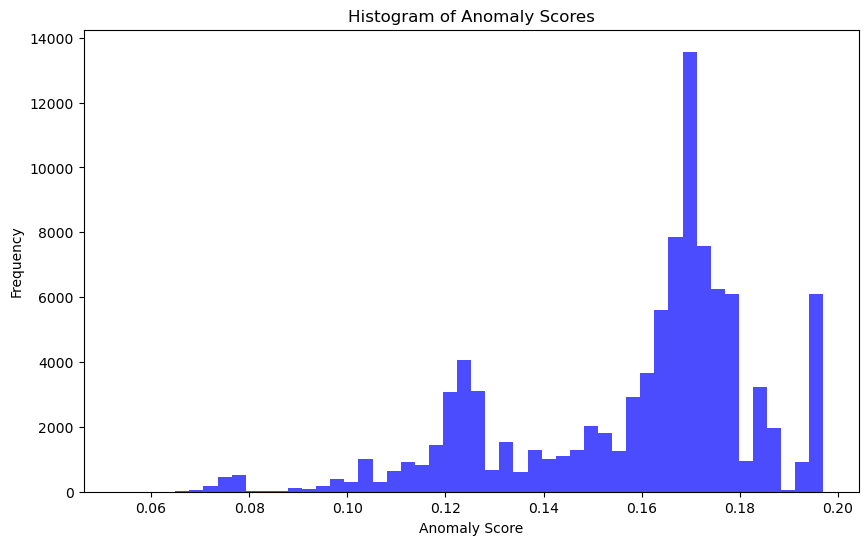

In [144]:
# Calculate anomaly scores (lower is more anomalous)
scores = iso_forest.decision_function(scaled_features)
combined_data['anomaly_score'] = scores

# Visualization of Anomaly Scores
plt.figure(figsize=(10, 6))
plt.hist(scores, bins=50, color='blue', alpha=0.7)
plt.title('Histogram of Anomaly Scores')
plt.xlabel('Anomaly Score')
plt.ylabel('Frequency')
plt.show()

From the histogram, we can see that the lowest point is close to 0.6, which indicates the threshold for anomalies.

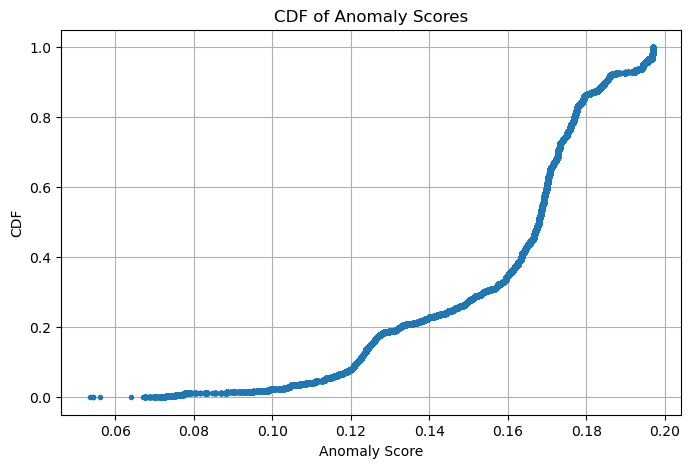

In [145]:
# Calculate the CDF of the anomaly scores
sorted_scores = np.sort(scores)
cdf = np.arange(len(sorted_scores)) / float(len(sorted_scores))

plt.figure(figsize=(8, 5))
plt.plot(sorted_scores, cdf, marker='.', linestyle='none')
plt.xlabel('Anomaly Score')
plt.ylabel('CDF')
plt.title('CDF of Anomaly Scores')
plt.grid(True)
plt.show()

In [146]:
# Set a threshold for anomaly detection
threshold = 0.06

# Mark data points with scores below the threshold as anomalies
combined_data['is_anomaly'] = combined_data['anomaly_score'] < threshold

# Display the anomalies
anomalies = combined_data[combined_data['is_anomaly']]
print(f"Detected {len(anomalies)} anomalies out of {len(combined_data)} records.")


Detected 4 anomalies out of 97090 records.


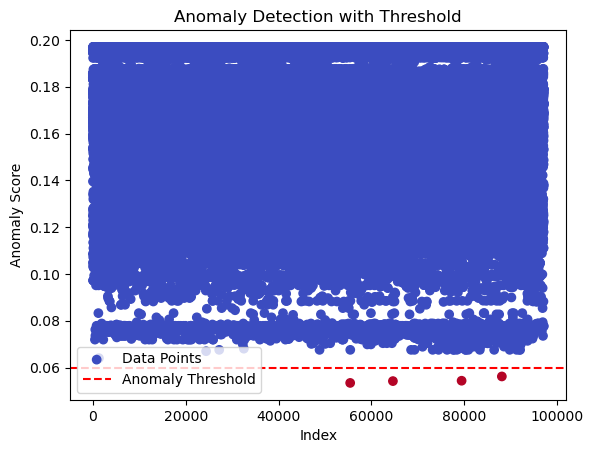

In [147]:
# Visualize the anomaly scores and the threshold
plt.scatter(combined_data.index, combined_data['anomaly_score'], c=combined_data['is_anomaly'], cmap='coolwarm', label='Data Points')
plt.axhline(y=threshold, color='red', linestyle='--', label='Anomaly Threshold')
plt.title('Anomaly Detection with Threshold')
plt.xlabel('Index')
plt.ylabel('Anomaly Score')
plt.legend()
plt.show()

## Anomaly Date

d:\Anaconda3\envs\prmls_new\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


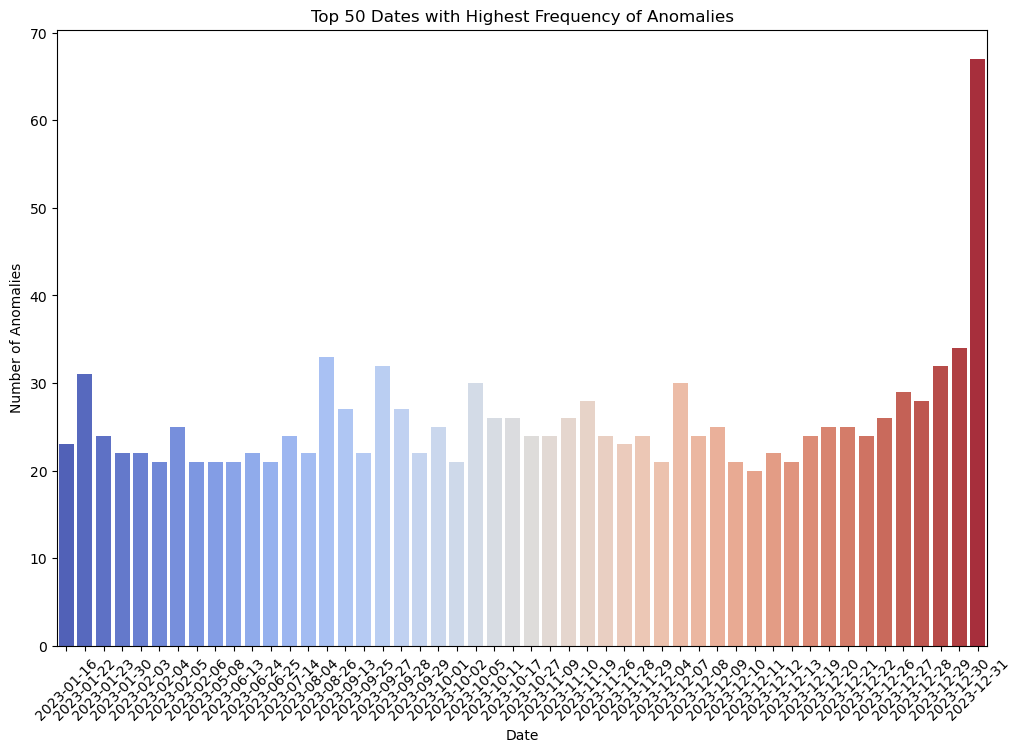

In [148]:
# Abstract the date and time (including the hour)
# anomalies_data_iso['Date_Hour'] = anomalies_data_iso['Arrival Time'].dt.floor('H')
anomalies_data_iso['Date'] = anomalies_data_iso['Arrival Time'].dt.date

# Calculate the number of anomalies for each date
# date_counts_iso = anomalies_data_iso['Date_Hour'].value_counts().nlargest(50)
date_counts_iso = anomalies_data_iso['Date'].value_counts().nlargest(50)

date_counts_iso = date_counts_iso.sort_index()

plt.figure(figsize=(12, 8))
sns.barplot(x=date_counts_iso.index, y=date_counts_iso.values, palette='coolwarm')
plt.xticks(rotation=45)
plt.title('Top 50 Dates with Highest Frequency of Anomalies')
plt.xlabel('Date')
plt.ylabel('Number of Anomalies')
plt.show()

In [155]:
df_iso = pd.DataFrame(date_counts_iso).reset_index()
df_iso.columns = ['Date', 'Count_Iso']
print(df_iso)

          Date  Count_Iso
0   2023-01-16         23
1   2023-01-22         31
2   2023-01-23         24
3   2023-01-30         22
4   2023-02-03         22
5   2023-02-04         21
6   2023-02-05         25
7   2023-02-06         21
8   2023-05-08         21
9   2023-06-13         21
10  2023-06-24         22
11  2023-06-25         21
12  2023-07-14         24
13  2023-08-04         22
14  2023-08-26         33
15  2023-09-13         27
16  2023-09-25         22
17  2023-09-27         32
18  2023-09-28         27
19  2023-09-29         22
20  2023-10-01         25
21  2023-10-02         21
22  2023-10-05         30
23  2023-10-11         26
24  2023-10-17         26
25  2023-10-27         24
26  2023-11-09         24
27  2023-11-10         26
28  2023-11-19         28
29  2023-11-26         24
30  2023-11-28         23
31  2023-11-29         24
32  2023-12-04         21
33  2023-12-07         30
34  2023-12-08         24
35  2023-12-09         25
36  2023-12-10         21
37  2023-12-

## Weather

In [200]:
# Combine the anomalies data with weather data
matched_weather_iso = pd.merge(df_iso, weather_data, on='Date', how='inner')
print(matched_weather_iso)

          Date  Count_Iso  tempmax  tempmin  temp  feelslikemax  feelslikemin  \
0   2023-01-16         23     25.2     16.8  21.3          25.2          16.8   
1   2023-01-22         31     24.6     14.8  19.8          24.6          14.8   
2   2023-01-23         24     24.1     17.2  19.3          24.1          17.2   
3   2023-01-30         22     23.0     14.2  18.4          23.0          14.2   
4   2023-02-03         22     26.6     19.1  22.6          26.6          19.1   
5   2023-02-04         21     23.6     20.0  21.7          23.6          20.0   
6   2023-02-05         25     24.0     17.4  20.6          24.0          17.4   
7   2023-02-06         21     27.0     16.8  21.3          26.9          16.8   
8   2023-05-08         21     38.5     22.1  29.7          35.8          22.1   
9   2023-06-13         21     39.6     30.7  35.7          47.4          34.0   
10  2023-06-24         22     42.0     30.4  35.5          48.5          34.3   
11  2023-06-25         21   

In [201]:
weather_summary = matched_weather_iso.describe()
print("Weather Features Summary:")
print(weather_summary)

Weather Features Summary:
       Count_Iso    tempmax    tempmin       temp  feelslikemax  feelslikemin  \
count  50.000000  50.000000  50.000000  50.000000     50.000000     50.000000   
mean   25.640000  31.956000  22.876000  27.292000     33.502000     23.662000   
std     6.951024   6.327948   5.929124   5.858008      8.864225      7.208212   
min    20.000000  23.000000  14.200000  18.400000     23.000000     14.200000   
25%    22.000000  27.150000  18.250000  22.850000     26.950000     18.250000   
50%    24.000000  29.400000  20.150000  24.900000     29.400000     20.150000   
75%    26.750000  38.000000  28.300000  33.025000     40.650000     29.900000   
max    67.000000  45.300000  35.800000  38.900000     53.300000     42.000000   

       feelslike        dew   humidity    precip  ...  windspeed     winddir  \
count  50.000000  50.000000  50.000000  50.00000  ...  50.000000   50.000000   
mean   28.722000  16.620000  55.418000   0.03600  ...  20.454000  212.922000   
std 

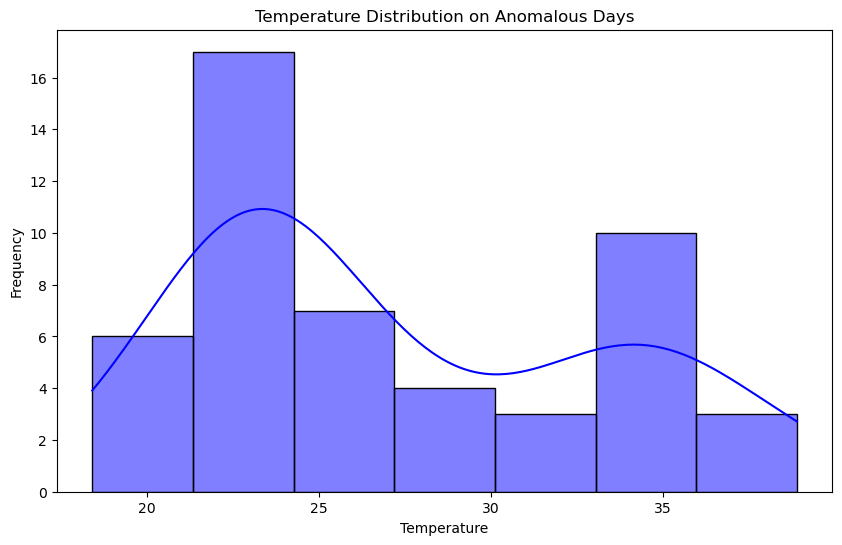

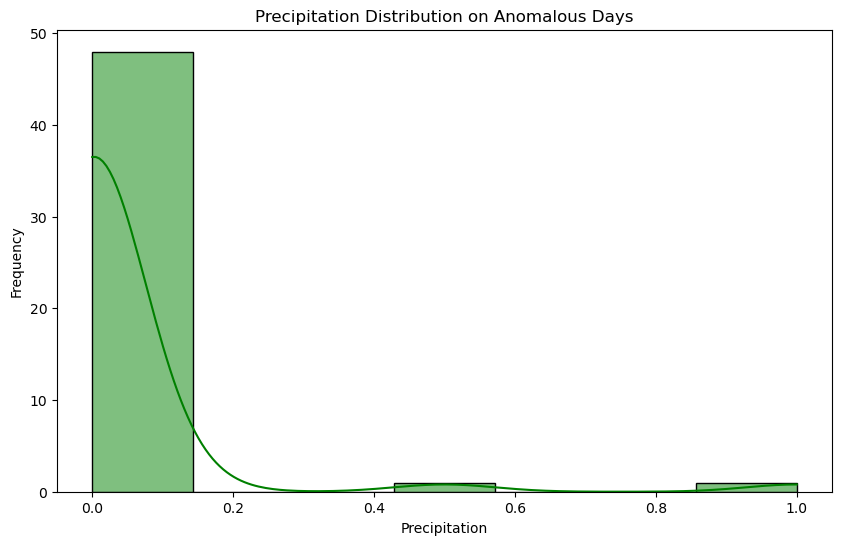

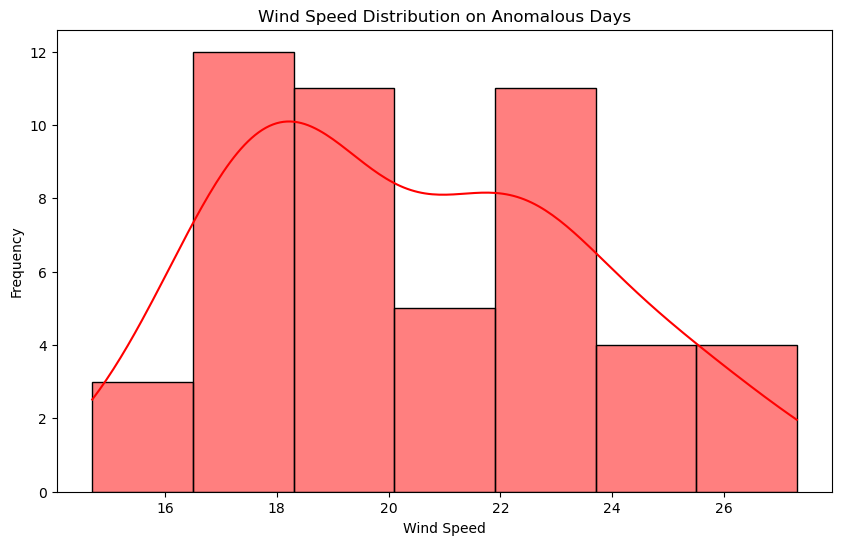

In [202]:
# Plot the weather features on anomalous days

# Temperature
plt.figure(figsize=(10, 6))
sns.histplot(matched_weather_iso['temp'], kde=True, color='blue')
plt.title('Temperature Distribution on Anomalous Days')
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.show()

# Precipitation
plt.figure(figsize=(10, 6))
sns.histplot(matched_weather_iso['precip'], kde=True, color='green')
plt.title('Precipitation Distribution on Anomalous Days')
plt.xlabel('Precipitation')
plt.ylabel('Frequency')
plt.show()

# Wind Speed
plt.figure(figsize=(10, 6))
sns.histplot(matched_weather_iso['windspeed'], kde=True, color='red')
plt.title('Wind Speed Distribution on Anomalous Days')
plt.xlabel('Wind Speed')
plt.ylabel('Frequency')
plt.show()

## Anomalies of Main Diagnosis

Number of Main Diagnoses for Anomalies: 53


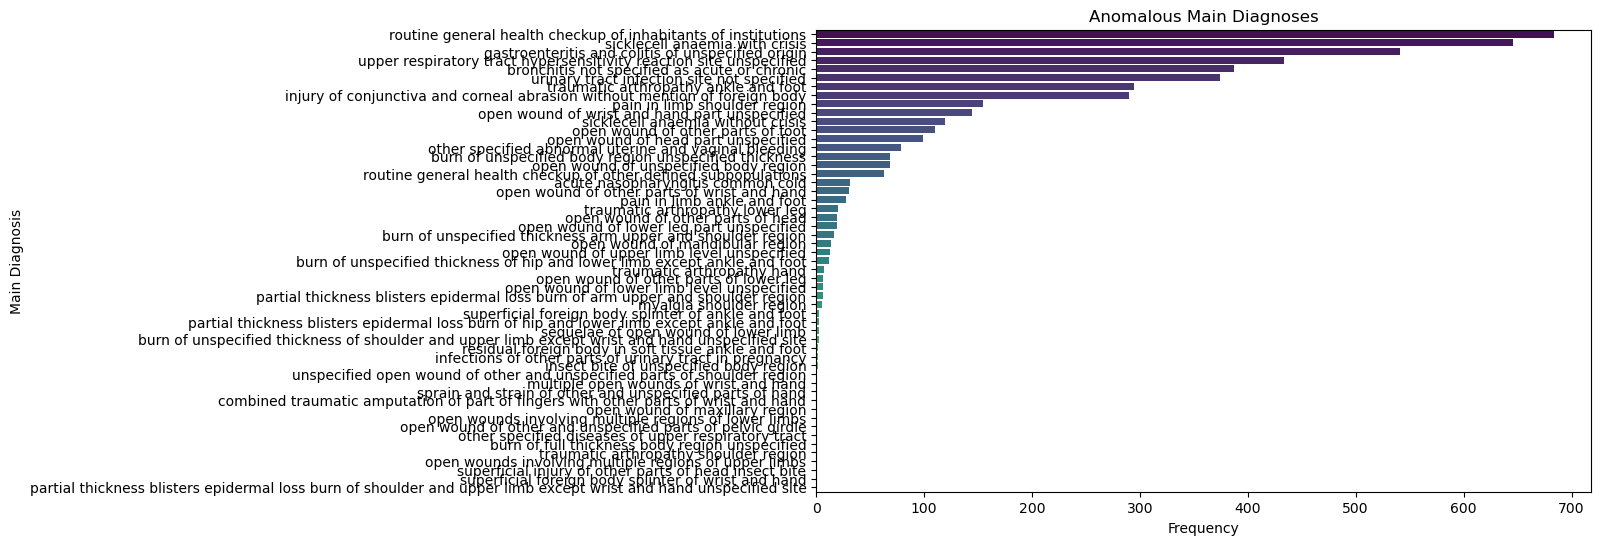

In [167]:
# Calculate the frequency of main diagnoses for anomalies
top_diagnoses_iso = anomalies_data_iso['Main Diagnosis'].value_counts()
print("Number of Main Diagnoses for Anomalies:",top_diagnoses_iso.count())

plt.figure(figsize=(10, 6))
sns.barplot(x=top_diagnoses_iso.values, y=top_diagnoses_iso.index, palette='viridis')
# sns.countplot(y='Main Diagnosis', data=anomalies_data_iso)
plt.title('Anomalous Main Diagnoses')
plt.xlabel('Frequency')
plt.ylabel('Main Diagnosis')
plt.show()

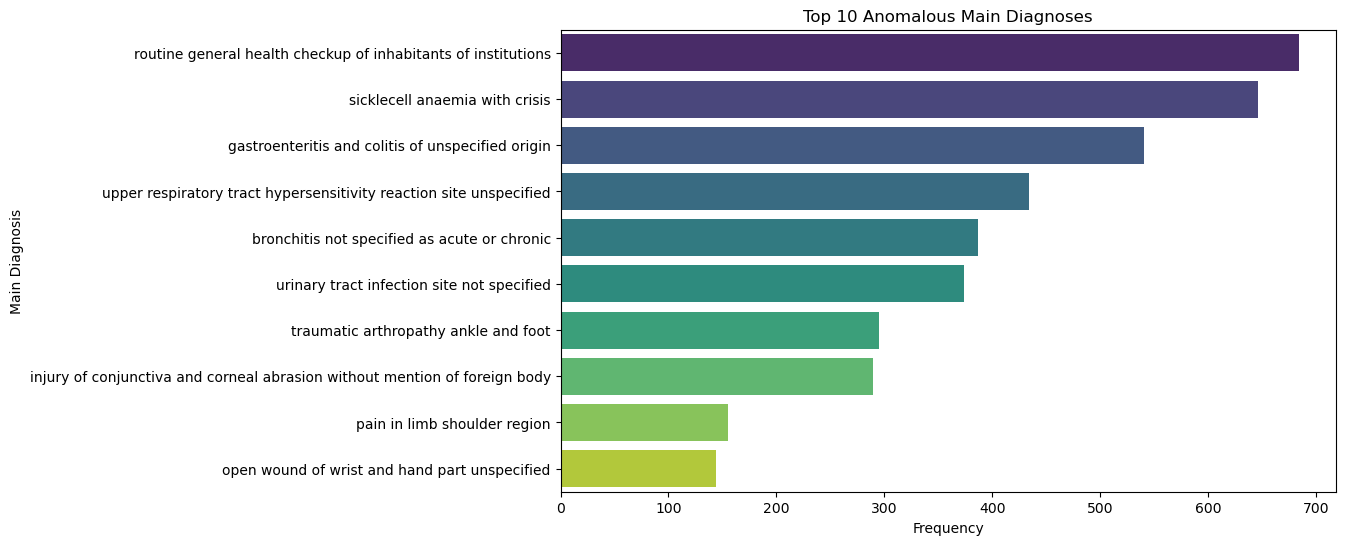

Top 10 Anomalous Main Diagnoses (Isolation Forest):
1. routine general health checkup of inhabitants of institutions
2. sicklecell anaemia with crisis
3. gastroenteritis and colitis of unspecified origin
4. upper respiratory tract hypersensitivity reaction site unspecified
5. bronchitis not specified as acute or chronic
6. urinary tract infection site not specified
7. traumatic arthropathy ankle and foot
8. injury of conjunctiva and corneal abrasion without mention of foreign body
9. pain in limb shoulder region
10. open wound of wrist and hand part unspecified


In [206]:
# Calculate the frequency of main diagnoses for anomalies
top_diagnoses_iso = anomalies_data_iso['Main Diagnosis'].value_counts().nlargest(10)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_diagnoses_iso.values, y=top_diagnoses_iso.index, palette='viridis')
plt.title('Top 10 Anomalous Main Diagnoses')
plt.xlabel('Frequency')
plt.ylabel('Main Diagnosis')
plt.show()

print("Top 10 Anomalous Main Diagnoses (Isolation Forest):")
for idx, diagnosis in enumerate(top_diagnoses_iso.index, start=1):
    print(f"{idx}. {diagnosis}")


# Compare the results of the two models

In [152]:
# Merge the DataFrame
merged_data = pd.merge(df_auto, df_iso, on='Date', how='inner')

merged_data.sort_values(by='Date', inplace=True)

print(merged_data)

         Date  Count_Auto  Count_Iso
0  2023-02-06           6         21
1  2023-08-26           5         33
2  2023-10-05           6         30


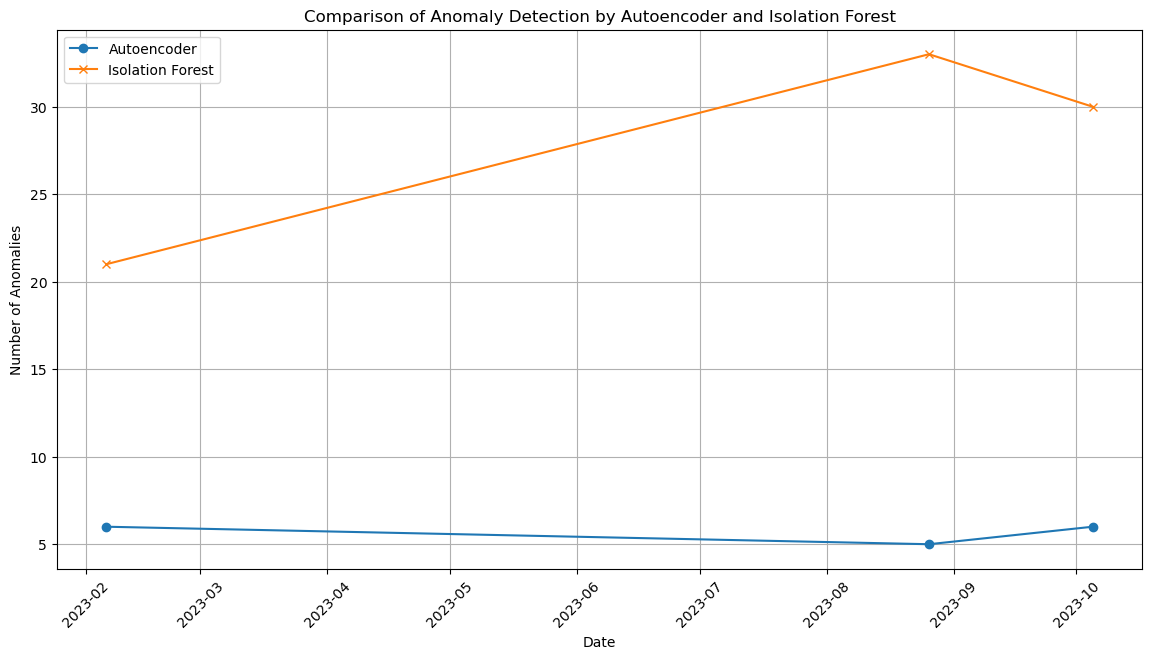

In [153]:
plt.figure(figsize=(14, 7))
plt.plot(merged_data['Date'], merged_data['Count_Auto'], label='Autoencoder', marker='o')
plt.plot(merged_data['Date'], merged_data['Count_Iso'], label='Isolation Forest', marker='x')
plt.xticks(rotation=45)
plt.title('Comparison of Anomaly Detection by Autoencoder and Isolation Forest')
plt.xlabel('Date')
plt.ylabel('Number of Anomalies')
plt.legend()
plt.grid(True)
plt.show()

In [174]:
# Main Diagnosis Comparison
# Autoencoder Top 100 Diagnoses
diagnosis_counts_auto = anomalies_data_auto['Main Diagnosis'].value_counts().nlargest(100)

# Isolation Forest Top 100 Diagnoses
top_diagnoses_iso = anomalies_data_iso['Main Diagnosis'].value_counts().nlargest(100)


set_auto = set(diagnosis_counts_auto.index)
set_iso = set(top_diagnoses_iso.index)

# Find the common diagnoses
common_diagnoses = set_auto.intersection(set_iso)

print("Common Anomalous Main Diagnoses between Autoencoder and Isolation Forest:")
for idx, diagnosis in enumerate(common_diagnoses, start=1):
    print(f"{idx}. {diagnosis}")


Common Anomalous Main Diagnoses between Autoencoder and Isolation Forest:
1. pain in limb ankle and foot
2. myalgia shoulder region
3. routine general health checkup of inhabitants of institutions
4. sicklecell anaemia with crisis
5. open wound of unspecified body region
6. acute nasopharyngitis common cold
7. urinary tract infection site not specified
8. open wound of wrist and hand part unspecified
9. bronchitis not specified as acute or chronic
10. pain in limb shoulder region
11. traumatic arthropathy ankle and foot
12. gastroenteritis and colitis of unspecified origin
